In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import numpy as np
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.1.0


# Using *ktrain* to Facilitate a Normal TensorFlow Workflow

This example notebook simply illustrates how *ktrain* can be used in a **minimally-invasive** way within
a normal TensorFlow workflow.  In this notebook, we will store our datasets in the form of `tf.Datasets` and build our own `tf.Keras` model following the example of TensorFlow's [Keras MNIST TPU.ipynb](https://colab.research.google.com/github/tensorflow/tpu/blob/master/tools/colab/keras_mnist_tpu.ipynb#scrollTo=cCpkS9C_H7Tl).  We will then simply use **ktrain** as a lightweight wrapper for our model and data to estimate a learning rate, train the model, inspect the model, and make predictions.

## Detect Hardware:  CPU vs. GPU vs. TPU

In [3]:
# Detect hardware
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select appropriate distribution strategy
if tpu:
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu, steps_per_run=128) # Going back and forth between TPU and host is expensive. Better to run 128 batches on the TPU before reporting back.
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on single GPU  /device:GPU:0
Number of accelerators:  1


## Prepare Training and Validation Data as `tf.Datasets`

Download the dataset files from [LeCun's website](http://yann.lecun.com/exdb/mnist/).

In [4]:
BATCH_SIZE = 64 * strategy.num_replicas_in_sync # Gobal batch size.
training_images_file   = 'data/mnist_lecun/train-images-idx3-ubyte'
training_labels_file   = 'data/mnist_lecun/train-labels-idx1-ubyte'
validation_images_file = 'data/mnist_lecun/t10k-images-idx3-ubyte'
validation_labels_file = 'data/mnist_lecun/t10k-labels-idx1-ubyte'

Note that, if training using a TPU, these should be set as follows:

```python
training_images_file   = 'gs://mnist-public/train-images-idx3-ubyte'
training_labels_file   = 'gs://mnist-public/train-labels-idx1-ubyte'
validation_images_file = 'gs://mnist-public/t10k-images-idx3-ubyte'
validation_labels_file = 'gs://mnist-public/t10k-labels-idx1-ubyte'
```

You may need to authenticate:
```python
IS_COLAB_BACKEND = 'COLAB_GPU' in os.environ  # this is always set on Colab, the value is 0 or 1 depending on GPU presence
if IS_COLAB_BACKEND:
  from google.colab import auth
  # Authenticates the Colab machine and also the TPU using your
  # credentials so that they can access your private GCS buckets.
  auth.authenticate_user()
```

In [5]:
def read_label(tf_bytestring):
    label = tf.io.decode_raw(tf_bytestring, tf.uint8)
    label = tf.reshape(label, [])
    label = tf.one_hot(label, 10)
    return label
  
def read_image(tf_bytestring):
    image = tf.io.decode_raw(tf_bytestring, tf.uint8)
    image = tf.cast(image, tf.float32)/255.0
    image = tf.reshape(image, [28*28])
    return image
  
def load_dataset(image_file, label_file):
    imagedataset = tf.data.FixedLengthRecordDataset(image_file, 28*28, header_bytes=16)
    imagedataset = imagedataset.map(read_image, num_parallel_calls=16)
    labelsdataset = tf.data.FixedLengthRecordDataset(label_file, 1, header_bytes=8)
    labelsdataset = labelsdataset.map(read_label, num_parallel_calls=16)
    dataset = tf.data.Dataset.zip((imagedataset, labelsdataset))
    return dataset 
  
def get_training_dataset(image_file, label_file, batch_size):
    dataset = load_dataset(image_file, label_file)
    dataset = dataset.cache()  # this small dataset can be entirely cached in RAM
    dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
    dataset = dataset.repeat() # Mandatory for Keras for now
    dataset = dataset.batch(batch_size, drop_remainder=True) # drop_remainder is important on TPU, batch size must be fixed
    dataset = dataset.prefetch(-1)  # fetch next batches while training on the current one (-1: autotune prefetch buffer size)
    return dataset
  
def get_validation_dataset(image_file, label_file):
    dataset = load_dataset(image_file, label_file)
    dataset = dataset.cache() # this small dataset can be entirely cached in RAM
    dataset = dataset.batch(10000, drop_remainder=True) # 10000 items in eval dataset, all in one batch
    dataset = dataset.repeat() # Mandatory for Keras for now
    return dataset

def load_label_dataset(label_file):
    labelsdataset = tf.data.FixedLengthRecordDataset(label_file, 1, header_bytes=8)
    labelsdataset = labelsdataset.map(read_label, num_parallel_calls=16)
    return labelsdataset 

# instantiate the datasets
training_dataset = get_training_dataset(training_images_file, training_labels_file, BATCH_SIZE)
validation_dataset = get_validation_dataset(validation_images_file, validation_labels_file)

# exract ground truth labels
training_labels = np.vstack(list(load_label_dataset(training_labels_file).as_numpy_iterator()))
validation_labels = np.vstack(list(load_label_dataset(validation_labels_file).as_numpy_iterator()))

## Build a Model

In [6]:
# This model trains to 99.4% accuracy in 10 epochs (with a batch size of 64)  

def make_model():
    model = tf.keras.Sequential(
      [
        tf.keras.layers.Reshape(input_shape=(28*28,), target_shape=(28, 28, 1), name="image"),

        tf.keras.layers.Conv2D(filters=12, kernel_size=3, padding='same', use_bias=False), # no bias necessary before batch norm
        tf.keras.layers.BatchNormalization(scale=False, center=True), # no batch norm scaling necessary before "relu"
        tf.keras.layers.Activation('relu'), # activation after batch norm

        tf.keras.layers.Conv2D(filters=24, kernel_size=6, padding='same', use_bias=False, strides=2),
        tf.keras.layers.BatchNormalization(scale=False, center=True),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Conv2D(filters=32, kernel_size=6, padding='same', use_bias=False, strides=2),
        tf.keras.layers.BatchNormalization(scale=False, center=True),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(200, use_bias=False),
        tf.keras.layers.BatchNormalization(scale=False, center=True),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.4), # Dropout on dense layer only

        tf.keras.layers.Dense(10, activation='softmax')
      ])

    model.compile(optimizer='adam', # learning rate will be set by LearningRateScheduler
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model
    
with strategy.scope():
    model = make_model()


# set up learning rate decay
LEARNING_RATE = 0.01
LEARNING_RATE_EXP_DECAY = 0.6 if strategy.num_replicas_in_sync == 1 else 0.7
lr_decay = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch,
    verbose=True)

## Use *ktrain* With Our Model and Data

### Wrap tf.Datasets in a `ktrain.TFDataset` wrapper and create `Learner`

In [7]:
import ktrain
trn = ktrain.TFDataset(training_dataset, n=training_labels.shape[0], y=training_labels)
val = ktrain.TFDataset(validation_dataset, n=validation_labels.shape[0], y=validation_labels)
learner = ktrain.get_learner(model, train_data=trn, val_data=val)

/home/amaiya/projects/ghub/ktrain/ktrain/data.py:86: UserWarning: batch_size parameter is ignored, as pre-configured batch_size of tf.data.Dataset is used
  warnings.warn('batch_size parameter is ignored, as pre-configured batch_size of tf.data.Dataset is used')


### Find Learning Rate

simulating training for different learning rates... this may take a few moments...
Train for 937 steps
Epoch 1/1024
937/937 [==============================] - 8s 8ms/step - loss: 1.8162 - accuracy: 0.4173
Epoch 2/1024
604/937 [==================>...........] - ETA: 2s - loss: 0.2286 - accuracy: 0.9345

done.
Visually inspect loss plot and select learning rate associated with falling loss


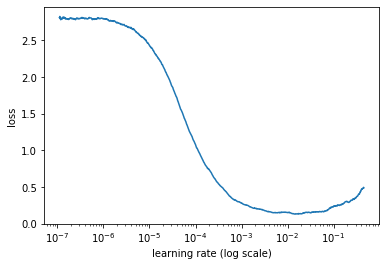

In [8]:
learner.lr_find(show_plot=True)

## Train the Model Using a Cosine Annealing LR Schedule

In [9]:
learner.fit(5e-3, 1, cycle_len=10, checkpoint_folder='/tmp/mymodel')

Train for 938 steps, validate for 1 steps
Epoch 1/10
938/938 [==============================] - 7s 8ms/step - loss: 0.1176 - accuracy: 0.9641 - val_loss: 0.0513 - val_accuracy: 0.9825
Epoch 2/10
938/938 [==============================] - 6s 7ms/step - loss: 0.0504 - accuracy: 0.9844 - val_loss: 0.0375 - val_accuracy: 0.9874
Epoch 3/10
938/938 [==============================] - 6s 6ms/step - loss: 0.0413 - accuracy: 0.9875 - val_loss: 0.0336 - val_accuracy: 0.9888
Epoch 4/10
938/938 [==============================] - 6s 6ms/step - loss: 0.0327 - accuracy: 0.9899 - val_loss: 0.0388 - val_accuracy: 0.9891
Epoch 5/10
938/938 [==============================] - 6s 6ms/step - loss: 0.0268 - accuracy: 0.9918 - val_loss: 0.0278 - val_accuracy: 0.9906
Epoch 6/10
938/938 [==============================] - 6s 6ms/step - loss: 0.0186 - accuracy: 0.9943 - val_loss: 0.0254 - val_accuracy: 0.9921
Epoch 7/10
938/938 [==============================] - 6s 6ms/step - loss: 0.0135 - accuracy: 0.9955 - val_

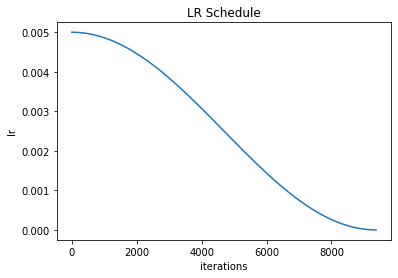

In [10]:
# cosine annealed LR schedule
learner.plot('lr')

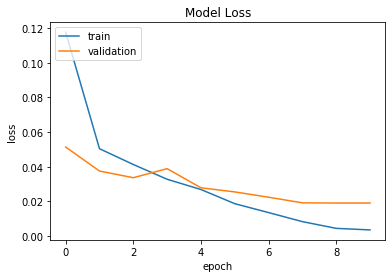

In [11]:
# training vs. validation loss
learner.plot('loss')

### Inspect Model

#### Evaluate as Normal

In [12]:
learner.model.evaluate(validation_dataset, steps=1)

1/1 [==============================] - 0s 57ms/step - loss: 0.0186 - accuracy: 0.9943


[0.018631214275956154, 0.9943]

#### Validation Metrics

In [14]:
learner.validate(class_names=list(map(str, range(10))))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       0.99      1.00      1.00      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       1.00      0.99      1.00      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



array([[ 979,    0,    0,    0,    0,    0,    0,    1,    0,    0],
       [   0, 1135,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    1, 1028,    0,    0,    0,    0,    3,    0,    0],
       [   0,    0,    2, 1003,    0,    4,    0,    0,    1,    0],
       [   0,    0,    0,    0,  975,    0,    4,    0,    0,    3],
       [   1,    0,    0,    7,    0,  883,    1,    0,    0,    0],
       [   3,    1,    0,    0,    0,    1,  951,    0,    2,    0],
       [   0,    2,    2,    0,    0,    0,    0, 1022,    0,    2],
       [   2,    0,    2,    1,    0,    0,    0,    0,  967,    2],
       [   0,    0,    0,    0,    5,    2,    0,    0,    2, 1000]])

#### View Top Losses

In [11]:
learner.view_top_losses(n=1)

----------
id:1014 | loss:7.4 | true:6 | pred:5)



### Making Predictions

In [26]:
preds = learner.predict(val)
preds = np.argmax(preds, axis=1)
actual = learner.ground_truth(val)
actual = np.argmax(actual, axis=1)

In [27]:
import pandas as pd
df = pd.DataFrame(zip(preds, actual), columns=['Predicted', 'Actual'])
df.head()

,Predicted,Actual
0,7,7
1,2,2
2,1,1
3,0,0
4,4,4


## Save Model and Reload Model

In [13]:
learner.save_model('/tmp/my_tf_model')

In [14]:
learner.load_model('/tmp/my_tf_model')

In [15]:
learner.model.evaluate(validation_dataset, steps=1)

1/1 [==============================] - 0s 176ms/step - loss: 0.0190 - accuracy: 0.9943


[0.018986882641911507, 0.9943]